In [1]:
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

In [2]:
def SCORE_method(A, K):
    # Ensure K is at least 2 for the method to make sense
    if K < 2:
        raise ValueError("K must be at least 2.")

    # Compute the K largest eigenvectors of the adjacency matrix A
    values, vectors = eigs(A, k=K, which='LR')  # 'LR' means Largest Real part
    vectors = np.real(vectors)  # Ensure the eigenvectors are real

    # Normalize the eigenvectors to have unit norm
    for i in range(K):
        vectors[:, i] = vectors[:, i] / np.linalg.norm(vectors[:, i], 2)
    
    # Form the ratio matrix R using the first eigenvector and the rest
    R = np.zeros((A.shape[0], K - 1))
    for i in range(1, K):
        R[:, i - 1] = vectors[:, i] / vectors[:, 0]
    
    # Apply k-means clustering to the ratio matrix
    kmeans = KMeans(n_clusters=K, random_state=0).fit(R)
    labels = kmeans.labels_
    
    return labels


In [3]:
def generate_community_graph(K, nodes_per_community=100, p_in=0.8, p_out=0.05):
    """
    Generate a synthetic graph with K communities using the stochastic block model.

    Parameters:
    - K: int, number of communities
    - nodes_per_community: int, number of nodes in each community
    - p_in: float, probability of edges within the same community
    - p_out: float, probability of edges between different communities

    Returns:
    - G: NetworkX graph, the generated graph with community labels as node attributes
    """
    # Total number of nodes
    N = K * nodes_per_community
    
    # Create a list of community labels for each node
    community_labels = np.repeat(np.arange(K), nodes_per_community)
    
    # Initialize the adjacency matrix
    A = np.zeros((N, N))
    
    # Fill in the adjacency matrix
    for i in range(N):
        for j in range(i + 1, N):
            if community_labels[i] == community_labels[j]:  # Nodes are in the same community
                if np.random.rand() < p_in:
                    A[i, j] = A[j, i] = 1
            else:  # Nodes are in different communities
                if np.random.rand() < p_out:
                    A[i, j] = A[j, i] = 1
                    
    # Create a NetworkX graph from the adjacency matrix
    G = nx.from_numpy_matrix(A)
    
    # Assign community labels to each node
    for i, label in enumerate(community_labels):
        G.nodes[i]['community'] = label
    
    return G

TypeError: '_AxesStack' object is not callable

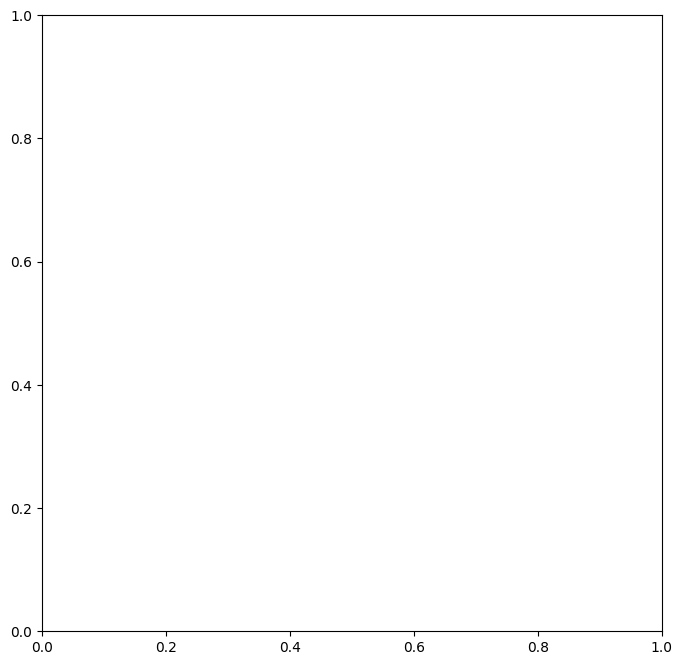

In [5]:
# Example usage
K = 3  # Number of communities
G = generate_community_graph(K)

# Visualize the generated graph (optional, for verification purposes)
import matplotlib.pyplot as plt

# Visualize the graph with predicted community labels
fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure and an axes object
pos = nx.spring_layout(G)  # Compute the layout

# Draw the graph specifying the axes object explicitly
colors = [G.nodes[i]['community'] for i in G.nodes]
nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.title("Synthetic Graph with {} Communities".format(K))
plt.show()

In [17]:
# Re-run the SCORE method with all necessary imports
predicted_labels = SCORE_method(A, K)

# Visualize the graph with predicted community labels
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=predicted_labels, with_labels=True, cmap=plt.cm.rainbow)
plt.title("Graph with Predicted Communities using SCORE")
plt.show()

predicted_labels

/Users/henryhe/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: '_AxesStack' object is not callable

<Figure size 800x800 with 0 Axes>